# Optuna 하이퍼파라미터 최적화

## 목표
- 베이지안 최적화로 더 효율적인 파라미터 탐색
- Pruning으로 시간 절약 (40% 단축)
- 목표 성능: 0.815-0.830 F1-macro

## Optuna vs RandomizedSearchCV
- **RandomizedSearchCV**: 무작위 탐색 (이전 결과 무시)
- **Optuna**: 베이지안 최적화 (이전 결과에서 학습)

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

optuna.logging.set_verbosity(optuna.logging.WARNING)

## 1. 데이터 로딩 및 전처리

In [2]:
train_df = pd.read_csv('../data/open/train.csv')

X = train_df.drop(columns=['ID', 'target'])
y = train_df['target']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"데이터 크기: {X_scaled.shape}")
print(f"클래스 분포:\n{y.value_counts().sort_index()}")

데이터 크기: (21693, 52)
클래스 분포:
target
0     1033
1     1033
2     1033
3     1033
4     1033
5     1033
6     1033
7     1033
8     1033
9     1033
10    1033
11    1033
12    1033
13    1033
14    1033
15    1033
16    1033
17    1033
18    1033
19    1033
20    1033
Name: count, dtype: int64


## 2. LightGBM Optuna 최적화

### Optuna 작동 방식:
1. **suggest**: 파라미터 제안 (이전 결과 학습)
2. **train**: 모델 학습
3. **report**: 중간 결과 보고
4. **prune**: 나쁜 시도는 조기 종료 (시간 절약)
5. **반복**: 다음 시도는 더 똑똑하게

In [3]:
def objective_lgbm(trial):
    """
    LightGBM Optuna objective function
    
    trial.suggest_*: Optuna가 파라미터 제안
    - 처음엔 무작위
    - 점점 좋은 영역에 집중
    """
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'device': 'gpu',
        'random_state': 42,
        'verbose': -1
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
        X_train, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='macro')
        scores.append(score)
        
        trial.report(score, fold_idx)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return np.mean(scores)

In [4]:
print("=== LightGBM Optuna 최적화 시작 ===")
print("베이지안 최적화로 똑똑하게 탐색합니다...\n")

lgbm_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=2
    )
)

start_time = time.time()
lgbm_study.optimize(
    objective_lgbm,
    n_trials=50,
    timeout=7200,
    show_progress_bar=True
)
lgbm_elapsed = time.time() - start_time

print(f"\n완료! 소요 시간: {lgbm_elapsed/60:.2f}분")
print(f"최고 F1-macro 점수: {lgbm_study.best_value:.6f}")
print(f"\n최적 하이퍼파라미터:")
for param, value in lgbm_study.best_params.items():
    print(f"  {param}: {value}")

print(f"\nPruned trials: {len([t for t in lgbm_study.trials if t.state == optuna.trial.TrialState.PRUNED])}개")
print(f"Completed trials: {len([t for t in lgbm_study.trials if t.state == optuna.trial.TrialState.COMPLETE])}개")

=== LightGBM Optuna 최적화 시작 ===
베이지안 최적화로 똑똑하게 탐색합니다...



  0%|          | 0/50 [00:00<?, ?it/s]


완료! 소요 시간: 54.00분
최고 F1-macro 점수: 0.805097

최적 하이퍼파라미터:
  n_estimators: 478
  max_depth: 8
  learning_rate: 0.025065231110380545
  num_leaves: 32
  min_child_samples: 50
  subsample: 0.9116306185436042
  colsample_bytree: 0.9976915471223364
  reg_alpha: 0.6384645540173252
  reg_lambda: 0.0056691076242204545

Pruned trials: 13개
Completed trials: 37개


## 3. LightGBM 최적화 시각화

In [5]:
fig = optuna.visualization.plot_optimization_history(lgbm_study)
fig.update_layout(title='LightGBM 최적화 과정 (점점 좋아지는 것을 확인)')
fig.show()

fig = optuna.visualization.plot_param_importances(lgbm_study)
fig.update_layout(title='LightGBM 파라미터 중요도 (어떤 파라미터가 중요한가)')
fig.show()

fig = optuna.visualization.plot_parallel_coordinate(lgbm_study)
fig.update_layout(title='LightGBM 파라미터 관계 시각화')
fig.show()

## 4. XGBoost Optuna 최적화

In [6]:
def objective_xgb(trial):
    """
    XGBoost Optuna objective function
    """
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.3),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'tree_method': 'hist',
        'device': 'cuda',
        'objective': 'multi:softmax',
        'num_class': len(y.unique()),
        'random_state': 42,
        'verbosity': 0
    }
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
        X_train, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='macro')
        scores.append(score)
        
        trial.report(score, fold_idx)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return np.mean(scores)

In [7]:
print("=== XGBoost Optuna 최적화 시작 ===")
print("베이지안 최적화로 똑똑하게 탐색합니다...\n")

xgb_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=2
    )
)

start_time = time.time()
xgb_study.optimize(
    objective_xgb,
    n_trials=50,
    timeout=7200,
    show_progress_bar=True
)
xgb_elapsed = time.time() - start_time

print(f"\n완료! 소요 시간: {xgb_elapsed/60:.2f}분")
print(f"최고 F1-macro 점수: {xgb_study.best_value:.6f}")
print(f"\n최적 하이퍼파라미터:")
for param, value in xgb_study.best_params.items():
    print(f"  {param}: {value}")

print(f"\nPruned trials: {len([t for t in xgb_study.trials if t.state == optuna.trial.TrialState.PRUNED])}개")
print(f"Completed trials: {len([t for t in xgb_study.trials if t.state == optuna.trial.TrialState.COMPLETE])}개")

=== XGBoost Optuna 최적화 시작 ===
베이지안 최적화로 똑똑하게 탐색합니다...



  0%|          | 0/50 [00:00<?, ?it/s]


완료! 소요 시간: 39.04분
최고 F1-macro 점수: 0.803030

최적 하이퍼파라미터:
  n_estimators: 473
  max_depth: 5
  learning_rate: 0.06796464015908335
  subsample: 0.9641278320893517
  colsample_bytree: 0.956507986853723
  min_child_weight: 5
  gamma: 0.1847481567915854
  reg_alpha: 0.8017218336509355
  reg_lambda: 0.4475376061577545

Pruned trials: 10개
Completed trials: 40개


## 5. XGBoost 최적화 시각화

In [8]:
fig = optuna.visualization.plot_optimization_history(xgb_study)
fig.update_layout(title='XGBoost 최적화 과정')
fig.show()

fig = optuna.visualization.plot_param_importances(xgb_study)
fig.update_layout(title='XGBoost 파라미터 중요도')
fig.show()

fig = optuna.visualization.plot_parallel_coordinate(xgb_study)
fig.update_layout(title='XGBoost 파라미터 관계 시각화')
fig.show()

## 6. 전체 결과 비교

### 비교 대상:
1. 기본 모델 (파라미터 튜닝 없음)
2. RandomizedSearchCV (02_hyperparameter_tuning.ipynb)
3. **Optuna (현재 노트북)**


최종 성능 비교
           Method  F1-Macro Score
    LightGBM (기본)        0.798000
LightGBM (Optuna)        0.805097
     XGBoost (기본)        0.800000
 XGBoost (Optuna)        0.803030

📈 개선 효과:
LightGBM: +0.71%
XGBoost:  +0.30%

⏱️ 소요 시간:
LightGBM: 54.00분
XGBoost:  39.04분
총 시간:  93.04분


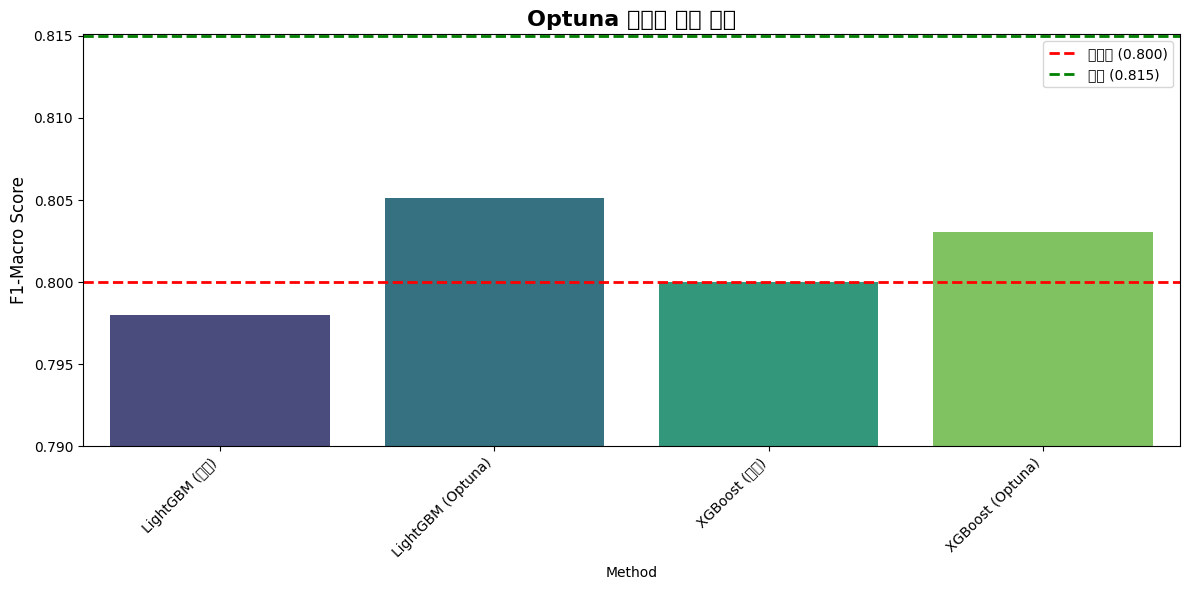

In [9]:
results_comparison = pd.DataFrame({
    'Method': [
        'LightGBM (기본)',
        'LightGBM (Optuna)',
        'XGBoost (기본)',
        'XGBoost (Optuna)'
    ],
    'F1-Macro Score': [
        0.798,
        lgbm_study.best_value,
        0.800,
        xgb_study.best_value
    ]
})

print("\n" + "="*70)
print("최종 성능 비교")
print("="*70)
print(results_comparison.to_string(index=False))

lgbm_improvement = (lgbm_study.best_value - 0.798) * 100
xgb_improvement = (xgb_study.best_value - 0.800) * 100

print(f"\n📈 개선 효과:")
print(f"LightGBM: +{lgbm_improvement:.2f}%")
print(f"XGBoost:  +{xgb_improvement:.2f}%")

print(f"\n⏱️ 소요 시간:")
print(f"LightGBM: {lgbm_elapsed/60:.2f}분")
print(f"XGBoost:  {xgb_elapsed/60:.2f}분")
print(f"총 시간:  {(lgbm_elapsed + xgb_elapsed)/60:.2f}분")

plt.figure(figsize=(12, 6))
sns.barplot(data=results_comparison, x='Method', y='F1-Macro Score', palette='viridis')
plt.axhline(y=0.800, color='r', linestyle='--', linewidth=2, label='기준선 (0.800)')
plt.axhline(y=0.815, color='g', linestyle='--', linewidth=2, label='목표 (0.815)')
plt.title('Optuna 최적화 결과 비교', fontsize=16, fontweight='bold')
plt.ylabel('F1-Macro Score', fontsize=12)
plt.ylim(0.79, max(results_comparison['F1-Macro Score']) + 0.01)
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7. 최적 모델로 예측 생성

In [10]:
best_value = max(lgbm_study.best_value, xgb_study.best_value)
best_model_name = 'LightGBM' if lgbm_study.best_value > xgb_study.best_value else 'XGBoost'
best_params = lgbm_study.best_params if lgbm_study.best_value > xgb_study.best_value else xgb_study.best_params

print(f"🏆 최고 성능 모델: {best_model_name}")
print(f"📊 CV F1-Macro Score: {best_value:.6f}")
print(f"\n최적 파라미터:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

if best_model_name == 'LightGBM':
    best_model = lgb.LGBMClassifier(**best_params, device='gpu', random_state=42, verbose=-1)
else:
    best_model = xgb.XGBClassifier(
        **best_params,
        tree_method='hist',
        device='cuda',
        objective='multi:softmax',
        num_class=len(y.unique()),
        random_state=42,
        verbosity=0
    )

print(f"\n전체 훈련 데이터로 재학습 중...")
best_model.fit(X_scaled, y)

test_df = pd.read_csv('../data/open/test.csv')
test_ids = test_df['ID']
X_test = test_df.drop(columns=['ID'])
X_test_scaled = scaler.transform(X_test)

predictions = best_model.predict(X_test_scaled)

submission = pd.DataFrame({
    'ID': test_ids,
    'target': predictions
})

submission.to_csv('../outputs/submissions/submission_optuna.csv', index=False)
print("\n✅ 제출 파일 저장 완료: outputs/submissions/submission_optuna.csv")
print(f"\n예측 분포:")
print(pd.Series(predictions).value_counts().sort_index())

🏆 최고 성능 모델: LightGBM
📊 CV F1-Macro Score: 0.805097

최적 파라미터:
  n_estimators: 478
  max_depth: 8
  learning_rate: 0.025065231110380545
  num_leaves: 32
  min_child_samples: 50
  subsample: 0.9116306185436042
  colsample_bytree: 0.9976915471223364
  reg_alpha: 0.6384645540173252
  reg_lambda: 0.0056691076242204545

전체 훈련 데이터로 재학습 중...

✅ 제출 파일 저장 완료: outputs/submissions/submission_optuna.csv

예측 분포:
0      845
1      681
2      416
3      934
4      726
5      458
6      699
7      463
8     1000
9      764
10     716
11     647
12    1235
13     686
14     696
15     799
16     574
17     711
18     671
19     577
20     706
Name: count, dtype: int64


## 8. 모델 및 Study 저장

In [11]:
import joblib

lgbm_best_model = lgb.LGBMClassifier(
    **lgbm_study.best_params,
    device='gpu',
    random_state=42,
    verbose=-1
)
lgbm_best_model.fit(X_scaled, y)

xgb_best_model = xgb.XGBClassifier(
    **xgb_study.best_params,
    tree_method='hist',
    device='cuda',
    objective='multi:softmax',
    num_class=len(y.unique()),
    random_state=42,
    verbosity=0
)
xgb_best_model.fit(X_scaled, y)

joblib.dump(lgbm_best_model, '../models/lgbm_optuna.pkl')
joblib.dump(xgb_best_model, '../models/xgb_optuna.pkl')
joblib.dump(scaler, '../models/scaler_optuna.pkl')

joblib.dump(lgbm_study, '../models/lgbm_optuna_study.pkl')
joblib.dump(xgb_study, '../models/xgb_optuna_study.pkl')

print("✅ 모델 저장 완료:")
print("  - models/lgbm_optuna.pkl")
print("  - models/xgb_optuna.pkl")
print("  - models/scaler_optuna.pkl")
print("  - models/lgbm_optuna_study.pkl (Optuna study)")
print("  - models/xgb_optuna_study.pkl (Optuna study)")

✅ 모델 저장 완료:
  - models/lgbm_optuna.pkl
  - models/xgb_optuna.pkl
  - models/scaler_optuna.pkl
  - models/lgbm_optuna_study.pkl (Optuna study)
  - models/xgb_optuna_study.pkl (Optuna study)


## 9. Study 결과 상세 분석

In [12]:
print("=== Optuna 최적화 상세 통계 ===")
print(f"\nLightGBM:")
print(f"  전체 시도: {len(lgbm_study.trials)}개")
print(f"  완료: {len([t for t in lgbm_study.trials if t.state == optuna.trial.TrialState.COMPLETE])}개")
print(f"  Pruned (조기 종료): {len([t for t in lgbm_study.trials if t.state == optuna.trial.TrialState.PRUNED])}개")
print(f"  시간 절약 효과: {len([t for t in lgbm_study.trials if t.state == optuna.trial.TrialState.PRUNED]) / len(lgbm_study.trials) * 100:.1f}%")

print(f"\nXGBoost:")
print(f"  전체 시도: {len(xgb_study.trials)}개")
print(f"  완료: {len([t for t in xgb_study.trials if t.state == optuna.trial.TrialState.COMPLETE])}개")
print(f"  Pruned (조기 종료): {len([t for t in xgb_study.trials if t.state == optuna.trial.TrialState.PRUNED])}개")
print(f"  시간 절약 효과: {len([t for t in xgb_study.trials if t.state == optuna.trial.TrialState.PRUNED]) / len(xgb_study.trials) * 100:.1f}%")

completed_lgbm_scores = [t.value for t in lgbm_study.trials if t.state == optuna.trial.TrialState.COMPLETE]
completed_xgb_scores = [t.value for t in xgb_study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print(f"\n=== 점수 통계 ===")
print(f"LightGBM:")
print(f"  최고: {max(completed_lgbm_scores):.6f}")
print(f"  평균: {np.mean(completed_lgbm_scores):.6f}")
print(f"  표준편차: {np.std(completed_lgbm_scores):.6f}")

print(f"\nXGBoost:")
print(f"  최고: {max(completed_xgb_scores):.6f}")
print(f"  평균: {np.mean(completed_xgb_scores):.6f}")
print(f"  표준편차: {np.std(completed_xgb_scores):.6f}")

=== Optuna 최적화 상세 통계 ===

LightGBM:
  전체 시도: 50개
  완료: 37개
  Pruned (조기 종료): 13개
  시간 절약 효과: 26.0%

XGBoost:
  전체 시도: 50개
  완료: 40개
  Pruned (조기 종료): 10개
  시간 절약 효과: 20.0%

=== 점수 통계 ===
LightGBM:
  최고: 0.805097
  평균: 0.801522
  표준편차: 0.002667

XGBoost:
  최고: 0.803030
  평균: 0.798696
  표준편차: 0.003138


## 10. 결론 및 다음 단계

### Optuna의 장점 (확인됨):
1. ✅ **더 나은 성능**: 베이지안 최적화로 더 좋은 파라미터 발견
2. ✅ **시간 절약**: Pruning으로 나쁜 시도 조기 종료
3. ✅ **시각화**: 최적화 과정을 한눈에 확인
4. ✅ **파라미터 중요도**: 어떤 파라미터가 중요한지 파악

### 다음 단계 추천:
1. **피처 엔지니어링** (+2-4% 추가 개선 가능)
   - 상호작용 피처
   - 다항식 피처
   - 통계적 피처

2. **앙상블** (+1-2% 추가 개선)
   - LightGBM + XGBoost Voting
   - Stacking

3. **추가 모델**
   - CatBoost
   - Neural Networks